# Hospital Waste Management LCA

In [1]:
import pandas as pd
import uuid
import math
from datetime import datetime
import numpy as np
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.graph_objects as go

import cvxpy as cp
import gurobipy

## Preliminary assumptions

For this, we choose to ignore the financial impacts of transporting waste from the hospital to the various disposal facilities. This is because we are focusing on large hospitals that are located in cities with these facilities easily accessible. Because of the locality of these facilities econonmic of the transportation.

# Name Definitions

In [2]:
disposal_method_names = ["Landfill", "Recycling", "Waste-to-Energy", "Composting", "Reuse"]
composition_type_names = ["Hard plastic", "Soft plastic", "Paper", "Food", "Textiles", "Glass", "Metal", "Electronic waste", "Sharps"]

In [3]:
# print utility
def print_mat(mat, rows, cols, round=2, title=''):
    print(title)
    temp_df = pd.DataFrame(mat, rows, cols)
    print(temp_df.round(round))

# Alternative Solutions

1) Replace single-use hard plastics with glass/metal autoclaving in hospital facility
    * Hard Plastics reduced by 30 wt.\%, shifted to glass and metal
        * Hard Plastics --> 19.907 >>> 13.93
        * Glass         -->  1.206 >>> 5.685
        * Metal         -->  0.402 >>> 1.895 
        * Glass and Metal all non-recycled shifted to sanitizated and reuse
2) Implement reusable gowns to entirely replace plastic single-use gowns
    * Soft-Plastics --> Reduced by 2\%
        * 46.081    >>> 44.081
    * Textiles      --> Increased by 2\%
        * 3.56      >>> 5.56
    * Textiles      --> Fully sanitized and reused
3) Seperate collection for compostable waste
    * All non-RMW food is composted
        * Landfill  >>>  1.495
        * Compost   >>> 98.505
4) Prioritize in order:
    * Compost
    * Santize and Reuse
    * Recycle
    * WtE
    * Landfill
7) Replace soft single-use plastics with biodegradable single use plastics
    * Not modeled

## Waste Stream Composition Scenarios

In [4]:
# types of waste
# Columns (must sum to 1.0):
# 0 - Hard plastic
# 1 - Soft plastic
# 2 - Paper
# 3 - Food
# 4 - Textiles
# 5 - Glass
# 6 - Metal
# 7 - Electronic waste
# 8 - Sharps

def normalize(arr):
    return arr / arr.sum()

# Baseline Input Scenario 0 (From Hsu et al., 2020)
print("Baseline Scenario " + '-' * 56 + '\n')
waste_composition_0 = np.array([130.93, 303.08, 123.546, 41.485,
                               23.415, 7.935, 2.645, 0.82, 23.85])
waste_composition_0_RWM = np.array([17.79, 13.305, 3.105, 0.62,
                                    4.72, 0.175, 0.04, 0.04, 23.85])
waste_composition_0_Rec = np.array([2.525, 0., 28.011, 0.,
                                    0., 1.02, 0.19, 0., 0.])
waste_RMW_prop_0 = waste_composition_0_RWM / waste_composition_0
waste_Rec_prop_0 = waste_composition_0_Rec / waste_composition_0
waste_composition_0 = normalize(waste_composition_0)
print("Material\t\tMass % Total    RMW % Material  Recycle % Material")
print("-" * 74)
for i in range(len(composition_type_names)):
    print(composition_type_names[i].ljust(16, ' ') + '\t' + str((waste_composition_0[i] * 100).round(3)) + '\t\t' + 
          str((100 * waste_RMW_prop_0[i]).round(3)) + '\t\t' + str((100 * waste_Rec_prop_0[i]).round(3)))

# Input Scenario 1 (Single-Use Hard Plastics -> Glass + Metal)
waste_composition_1 = np.copy(waste_composition_0) * 100
waste_composition_1[0] = 13.93
waste_composition_1[5] = 5.685
waste_composition_1[6] = 1.895
waste_composition_1 = normalize(waste_composition_1)

# Input Scenario 2 (Implement reusable gowns)
waste_composition_2 = np.copy(waste_composition_0) * 100
waste_composition_2[1] -= 2
waste_composition_2[4] += 2
waste_composition_2 = normalize(waste_composition_2)

# Input Scenario 3 (Both practices implemented)
waste_composition_3 = np.copy(waste_composition_1) * 100
waste_composition_3[1] -= 2
waste_composition_3[4] += 2
waste_composition_3 = normalize(waste_composition_3)

waste_compositions = [waste_composition_0, waste_composition_1,
                      waste_composition_2, waste_composition_3]

waste_composition_labels = ['Baseline', 'Replace Hard Plastics', 'Reusable Gowns', 'Combine Methods']

Baseline Scenario --------------------------------------------------------

Material		Mass % Total    RMW % Material  Recycle % Material
--------------------------------------------------------------------------
Hard plastic    	19.907		13.587		1.929
Soft plastic    	46.081		4.39		0.0
Paper           	18.784		2.513		22.673
Food            	6.308		1.495		0.0
Textiles        	3.56		20.158		0.0
Glass           	1.206		2.205		12.854
Metal           	0.402		1.512		7.183
Electronic waste	0.125		4.878		0.0
Sharps          	3.626		100.0		0.0


## Waste Disposal Method Scenarios

In [5]:
# Waste Disposal Methods
# Rows:
# 0 - Landfill
# 1 - Recycling
# 2 - WtE (incineration)
# 3 - Composting
# 4 - Sanitize and Reuse
# Columns (must sum to 1.0):
# 0 - Hard plastic
# 1 - Soft plastic
# 2 - Paper
# 3 - Food
# 4 - Textiles
# 5 - Glass
# 6 - Metal
# 7 - Electronic waste
# 8 - Sharps

# Data must be decided on by the team

# Worst-case method 0 (all landfill, hazardous waste to incinerators)
waste_treatment_0 = np.array([np.array([1.0] * 9) - waste_Rec_prop_0,
                              waste_Rec_prop_0,
                              [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                              [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                              [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

# Waste treatment method 1 - Shift non-recycled glass+metal to sanitize and reuse
waste_treatment_1 = np.copy(waste_treatment_0)
waste_treatment_1[4][5] = waste_treatment_1[0][5]
waste_treatment_1[4][6] = waste_treatment_1[0][6]
waste_treatment_1[0][5] = 0.
waste_treatment_1[0][6] = 0.

# Waste treatment method 2 - Shift from single-use gowns to reusable gowns
waste_treatment_2 = np.copy(waste_treatment_0)
waste_treatment_2[4][4] = waste_treatment_2[0][4]
waste_treatment_2[0][4] = 0.

# Waste treatment method 3 - Compost food
waste_treatment_3 = np.copy(waste_treatment_0)
waste_treatment_3[0][3] = 0.
waste_treatment_3[2][3] = waste_RMW_prop_0[3]
waste_treatment_3[3][3] = 1. - waste_RMW_prop_0[3]

# Waste treatment method 4 - All methods together
delta_10 = waste_treatment_1 - waste_treatment_0
delta_20 = waste_treatment_2 - waste_treatment_0
delta_30 = waste_treatment_3 - waste_treatment_0
waste_treatment_4 = np.copy(waste_treatment_0) + delta_10 + delta_20 + delta_30

# Waste treatment method 5 - Both methods + Prioritize Minimizing CO2 Emissions
waste_treatment_5 = np.copy(waste_treatment_3)
# Change hard plastic landfilling to sanitization and reuse
waste_treatment_5[0][0] = 0.
waste_treatment_5[1][0] = 0.
waste_treatment_5[4][0] = 1.
# Change paper to WtE
waste_treatment_5[0][2] = 0.
waste_treatment_5[1][2] = 0.
waste_treatment_5[2][2] = 1.
# Change food to full composting (RMW to WtE)
waste_treatment_5[0][3] = 0.
waste_treatment_5[2][3] = waste_RMW_prop_0[3]
waste_treatment_5[3][3] = 1. - waste_RMW_prop_0[3]
# Change textiles to reuse
waste_treatment_5[0][4] = 0.
waste_treatment_5[4][4] = 1.
# Change glass to reuse
waste_treatment_5[0][5] = 0.
waste_treatment_5[1][5] = 0.
waste_treatment_5[4][5] = 1.
# Change metals to reuse
waste_treatment_5[0][6] = 0.
waste_treatment_5[1][6] = 0.
waste_treatment_5[4][6] = 1.
# Electronic Waste kept the same
# Change sharps to sterilization and reuse
waste_treatment_5[0][8] = 0.
waste_treatment_5[4][8] = 1.

# Waste treatment method 6 - Both methods + Prioritize Minimizing Overall Impact
waste_treatment_6 = np.copy(waste_treatment_3)
# Change hard plastic landfilling to recycling (RMW to landfill)
waste_treatment_6[1][0] = 1. - waste_RMW_prop_0[0]
waste_treatment_6[0][0] = waste_RMW_prop_0[0]
# Change paper to full WtE
waste_treatment_6[0][2] = 0.
waste_treatment_6[1][2] = 0.
waste_treatment_6[2][2] = 1.
# Change food to full composting (RMW to WtE)
waste_treatment_6[0][3] = 0.
waste_treatment_6[2][3] = waste_RMW_prop_0[3]
waste_treatment_6[3][3] = 1. - waste_RMW_prop_0[3]
# Change textiles to WtE
waste_treatment_6[0][4] = 0.
waste_treatment_6[2][4] = 1.
# Change glass to recycling (RMW to WtE)
waste_treatment_6[0][5] = 0.
waste_treatment_6[1][5] = 1. - waste_RMW_prop_0[5]
waste_treatment_6[2][5] = waste_RMW_prop_0[5]
# Change metals to WtE
waste_treatment_6[0][6] = 0.
waste_treatment_6[1][6] = 0.
waste_treatment_6[2][6] = 1.
# Electronic Waste kept the same
# Change sharps to WtE
waste_treatment_6[0][8] = 0.
waste_treatment_6[2][8] = 1.
print_mat(waste_treatment_6, disposal_method_names, composition_type_names, title='Priority Tot')

waste_methods = [waste_treatment_0, waste_treatment_1, waste_treatment_2,
                 waste_treatment_3, waste_treatment_4, waste_treatment_5,
                 waste_treatment_6]
waste_method_labels = ['Baseline', 'Replace Hard Plastics', 'Reusable Gowns', 'Compost', 'Combine Methods', 'Prioritize Emissions', 'Prioritize Overall Impact']

Priority Tot
                 Hard plastic  Soft plastic  Paper  Food  Textiles  Glass  \
Landfill                 0.14           1.0    0.0  0.00       0.0   0.00   
Recycling                0.86           0.0    0.0  0.00       0.0   0.98   
Waste-to-Energy          0.00           0.0    1.0  0.01       1.0   0.02   
Composting               0.00           0.0    0.0  0.99       0.0   0.00   
Reuse                    0.00           0.0    0.0  0.00       0.0   0.00   

                 Metal  Electronic waste  Sharps  
Landfill           0.0               1.0     0.0  
Recycling          0.0               0.0     0.0  
Waste-to-Energy    1.0               0.0     1.0  
Composting         0.0               0.0     0.0  
Reuse              0.0               0.0     0.0  


## Impact Factor Variables

In [6]:
# Emissions Factors
# Rows:
# 0 - Landfill
# 1 - Recycling
# 2 - WtE (incineration)
# 3 - Composting
# 4 - Sanitize and Reuse
# Columns:
# 0 - Hard plastic (HDPE)
# 1 - Soft plastic (LDPE)
# 2 - Paper
# 3 - Food
# 4 - Textiles
# 5 - Glass
# 6 - Metal
# 7 - Electronic waste
# 8 - Sharps

# Data must be found for 'impact_cost' and 'impact_co2_eq'. 'impact_community' can be decided upon subjectively

inf = sys.float_info.max
inf = 100000

# Metric ton to short ton
mt_to_st = 1.10231

# Social cost of carbon (USD/ton CO2-eq)
social_cost_carbon = 190.0

# Cost multiplier of RMW (for Landfill, WtE, Incinerator)
RMW_cost_factor = 10.0

# Emissions factor for landfills by mass (ton CO2-eq/ton MSW)
landfill_emissions_factor = 2.5

# Emissions factor for energy in PA (ton CO2-eq/kWh)
energy_emissions_factor_20  = 1/2000. * (672.8 * 1. + 0.049 * 72. + 0.007 * 289.) / 1000.
energy_emissions_factor_100 = 1/2000. * (672.8 * 1. + 0.049 * 25. + 0.007 * 298.) / 1000.
print(energy_emissions_factor_100, energy_emissions_factor_20)

# Additional tipping fee for RMW
RMW_tipping_fee = 800.

# Cost of process (values in $/short ton waste)
impact_cost = np.array([[58.47] * 9,
                        [106.0] * 9,
                        [63.69] * 9,
                        [67.53] * 9,
                        [997.9] * 9])

# CO2 Emissions of process (metric ton CO2-eq/short ton waste)
impact_co2_eq = np.array([[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02],
                          [0.21,  inf, 0.07,  inf,  inf, 0.05, 0.23,  inf, 0.32],
                          [2.80, 2.80, 0.05, 0.05, 1.68, 0.01, 0.01,  inf, 0.01],
                          [ inf,  inf,  inf, 0.15,  inf,  inf,  inf,  inf,  inf],
                          [0.15,  inf,  inf,  inf, 0.15, 0.15, 0.15,  inf, 0.15]])
impact_co2_eq *= mt_to_st

# Waste mass that ends up in landfills (short ton waste/short ton waste)
impact_mass   = np.array([[1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],      
                          [0.70, 0.70, 0.32,  inf,  inf, 0.05, 0.10,  inf,  inf],
                          [0.30, 0.30, 0.30, 0.30, 0.30, 0.30, 0.30, 0.30, 0.30],
                          [ inf,  inf,  inf, 0.00,  inf,  inf,  inf,  inf,  inf],
                          [0.0217,  inf,  inf,  inf, 0.0133, 0.0025, 0.001,  inf, 0.00862]])

# Energy impact, negative indicates energy production (kWh/short ton waste)
impact_energy   = np.array([[-65., -65., -65., -65., -65., -65., -65., -65., -65.],
                            [7.08,  inf, 7.08,  inf,  inf, 7.08, 7.08,  inf, 7.08],
                            [-550, -550, -550, -550, -550, -550, -550, -550, -550],
                            [ inf,  inf,  inf, 0.15,  inf,  inf,  inf,  inf,  inf],
                            [0.02, 0.02, 0.80, 0.58, 0.02, 0.02, 0.02, 0.02, 0.02]])

# Total CO2 impact
impact_co2_total_100 = (impact_energy * energy_emissions_factor_100) + impact_co2_eq + (impact_mass * landfill_emissions_factor)
print_mat(impact_co2_total_100, disposal_method_names, composition_type_names, title='CO2 Impact 100 Years')

impact_co2_total_20 = (impact_energy * energy_emissions_factor_20) + impact_co2_eq + (impact_mass * landfill_emissions_factor)
print_mat(impact_co2_total_20, disposal_method_names, composition_type_names, title='CO2 Impact 20 Years')

# Total impact of process
impact_total_100  = ((impact_energy * energy_emissions_factor_100) + impact_co2_eq + (impact_mass * landfill_emissions_factor)) * social_cost_carbon + impact_cost
print_mat(impact_total_100, disposal_method_names, composition_type_names, title='Total Impact 100 Years')

impact_total_20  = ((impact_energy * energy_emissions_factor_20) + impact_co2_eq + (impact_mass * landfill_emissions_factor)) * social_cost_carbon + impact_cost
print_mat(impact_total_20, disposal_method_names, composition_type_names, title='Total Impact 20 Years')

0.0003380555 0.0003391755
CO2 Impact 100 Years
                 Hard plastic  Soft plastic      Paper       Food   Textiles  \
Landfill                 2.50          2.50       2.50       2.50       2.50   
Recycling                1.98     110266.56       0.88  360264.81  360264.81   
Waste-to-Energy          3.65          3.65       0.62       0.62       2.42   
Composting          360264.81     360264.81  360264.81       0.17  360264.81   
Reuse                    0.22     360231.00  360231.00  360231.00       0.20   

                     Glass      Metal  Electronic waste     Sharps  
Landfill              2.50       2.50              2.50       2.50  
Recycling             0.18       0.51         360264.81  250000.36  
Waste-to-Energy       0.58       0.58         110231.56       0.58  
Composting       360264.81  360264.81         360264.81  360264.81  
Reuse                 0.17       0.17         360231.00       0.19  
CO2 Impact 20 Years
                 Hard plastic  Soft pl

Municipal Solid Waste (MSW) Landfill	$60.34
MSW Recycling Center	$52.33
MSW Waste-to-Energy Facility	$102.13
Composting Facility	$20-$80
Incinerator Facility	$100-$200

Data sources:

Tipping fees:
* Tipping fee (landfill, PA, 2020): https://assets.website-files.com/602b605a94315c491a4fb4b8/610aed49f0ef85f4566dbe3f_Tipping-Fees-Data-Summary%20Jan%202021.pdf
* Tipping fee (recycling, PA): https://www.phila.gov/media/20210614135759/Municipal-Waste-Management-Plan-appendix-C.pdf
* WtE Facility, PA: https://www.covanta.com/where-we-are/our-facilities/plymouth
* Composting (to energy, PA): https://www.phila.gov/media/20210614135413/Municipal-Waste-Management-Plan-202010.pdf
* https://kleinmanenergy.upenn.edu/research/publications/powering-our-future-with-trash/ 
* Autoclave cost: https://www.sciencedirect.com/science/article/pii/S0956053X12004606
* RMW vs. MSW: https://www.redbag.com/part-1-are-you-throwing-away-money-your-waste-removal-practices
* RMW Extra Cost: https://practicegreenhealth.org/sites/default/files/upload-files/gorimpmod-rmwsegintheor_r5_web_0.pdf

Emissions data:
* Plastic types (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151894/)
* GHG 2022 Emission factors (https://www.epa.gov/climateleadership/ghg-emission-factors-hub)
* SBS Sterilization Data: https://watermark.silverchair.com/znab406.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA7YwggOyBgkqhkiG9w0BBwagggOjMIIDnwIBADCCA5gGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM3OHq1IzFvoFjSy8PAgEQgIIDaZSJ22zntvV7jr1oyTZMLrQxh5j0mbPV8rf5F-Oy5wEWimyOdXsRKDO38Ekew4gnEujpFZM-GQjBqUdGOG9ZxpVVaNtjtIO_1Lb2f2YaBPHUtX57aJQz3BLscMa1FkiFIPeZmps3HwN9KpAmE8Olmhuz6B2x2CCydkj9eT85Aba2WdmRpQydvf81zB5uYLzMOlhqUMnouJV-M_YELnJuOSrNTaL_ZsKFkAMeyyhKSyxmfoZcVUFRgjPev1G_dvQD-dwirS-3C2PFucLA3g77vwoPP6vOSOj_IVU0L1RwmQ9JQQgJEgPOZBiFZG5N9AfsZVbho1Ik-kllU8EgYGwCtYIW783Pv2wTO5v7SRzIqsYHqBFyLRNEDiUCPsNJYU-czLLa2VPW3mGJgtfsYs82bBAcB_l-YV_AtKCvnGx0rGRSjtOmVEE05yXIy-Uf5q-Rfx4qsiTcksIwCU-Z3Yt020pa6xg9duTTDS0pzRCS8Zjx21z4-XTrHaTI_s7RBVcNWe4Df6aCoxYHQ6OSV2SObHzIYpVlqIXY5t5aeb1FqmYjdSAk4j7r1a-0F8in5h0esLgxhIYCZCLL8ZVwL8ABwf_lk4F2rZIgvYyBWSk0IMt7LMA1DfFMigjegwo8Hgx9LQZDpE9AZugM-Fn9VfIvBOwbZ2r8DHhVWPI10C9wvmr4rK4fDOXRyz9sGB15-ujAAMsuBUCTQzyzHjAFAHBITorzJzeCSakkQe-15rflv2wDEFUPX7BxyY0KM2pJ_Y1I7FsvtdfACac8Eqxa4OIKmhu51pfKSh78PV07Qpnd-xXMTprBVc48L-dLauUT5Za8gcF7hJOh1AfdZnXnRtLAvx7sCl34jYaov3AraelqVfnBui2Amq3hEbxfbMJaMfqp70h7pxkKrW0-n9SZqCywGQeUae3wSqbM6IaENaWwYt6paFSV5WB1URAG8wNOF876qZp-105nlqHo23GFbHS_KElumAZ0CxM2R6g7z0F84IAcnABG5l_Ljb4P5zT4B_KRRtewkLlsBBzGkgKsZFCOg4CCbPCy8gyn4ryerws8OADU62JiY_6wJyFtmDT9KTYhiMndFYHnFYA_3ROydcO92I73nPgk8eZCuYAabNLOZCK2J-o91mu2ovRotkibZyspM34NvftqqXH7uQ
* IPCC GWP: https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch2s2-10-2.html

Energy consumption
* Recycling: https://pubmed.ncbi.nlm.nih.gov/25301544/#:~:text=Electricity%20use%20ranged%20from%204.7,than%2010%25%20of%20total%20electricity.

Social Cost of Carbon:
* https://www.brookings.edu/articles/what-is-the-social-cost-of-carbon/#:~:text=The%20social%20cost%20of%20carbon%20(SCC)%20is%20an%20estimate%20of,a%20ton%20of%20carbon%20emissions.
* https://www.epa.gov/system/files/documents/2022-11/epa_scghg_report_draft_0.pdf
* Landfill mass emissions factor: https://www.ieabioenergy.com/wp-content/uploads/2013/10/40_IEAPositionPaperMSW.pdf

Mass sources: 
* Paper efficiency: https://www.afandpa.org/news/2023/does-paper-actually-get-recycled-industry-answers
* HDPE efficiency: https://www.sciencedirect.com/science/article/pii/S2238785423013145#:~:text=The%20recycling%20rate%20of%20HDPE,for%20further%20processing%20%5B3%5D.
* LDPE efficiency: https://www.sciencedirect.com/science/article/pii/S2667378922000645#:~:text=The%20exemplary%20case%20study%20shows,that%20offer%20future%20research%20need.
* Glass efficiency: https://www.gpi.org/glass-recycling-facts
* Metal (aluminum) efficiency: https://www.aluminum.org/Recycling#:~:text=Infinitely%20Recyclable,process%20can%20happen%20virtually%20infinitely.
* Incineration efficiency: https://www.eia.gov/energyexplained/biomass/waste-to-energy-in-depth.php


In [7]:
def assess_impact(composition, methods, factors, name=None):
    # print(composition.shape, methods.shape, factors.shape)
    final_impact_matrix = (composition * methods) * factors
    verbose = name != None
    if verbose:
        print("-" * 50)
        print("Analyzing Scenario: " + str(name) + '\n------------------------\n')
        # print(final_impact_matrix)
        print("\nTotal " + str(name) + ": " + str(sum(sum(final_impact_matrix)).round(3)) + " per ton waste")
        print("\n\tBreakdown per ton:\n\t------------------------------")
        for i in range(len(disposal_method_names)):
            print('\t' + (disposal_method_names[i] + " " + name).ljust(24) + str(sum(final_impact_matrix[i]).round(3)))
        print()
        for i in range(len(composition_type_names)):
            print('\t' + (composition_type_names[i] + " " + name).ljust(24) + str(sum(final_impact_matrix)[i].round(3)))
        print()
        print("-" * 50)
    return final_impact_matrix

def minimize_impact(composition, impact_factors, RMW_constraints, RMW_cost=0):
    x = cp.Variable((5, 9), nonneg=True)
    RMW_extra_cost = 0.

    obj = cp.Minimize(sum((cp.multiply(x, impact_factors) @ composition)) + RMW_extra_cost)
    con_set = []
    for i in range(len(composition)):
        RMW_extra_cost = RMW_cost * (x[0,i] + x[2,i])
        con_set.append(sum(x[:,i]) == 1.0)
        con_set.append(x[0,i] + x[2,i] + x[4,i] >= RMW_constraints[i])

    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")
    print(obj.value)
    return x.value

In [8]:
# Assess impact of different waste stream compositions and disposal methods over CO2, cost, and total impact KPIs
results_co2  = []
results_tot  = []
results_cost = []
for method in waste_methods:
    row_co2  = []
    row_tot  = []
    row_cost = []
    for composition in waste_compositions:
        row_co2.append(sum(sum(assess_impact(composition, method, impact_co2_total_20))))
        row_tot.append(sum(sum(assess_impact(composition, method, impact_total_20))))
        row_cost.append(sum(sum(assess_impact(composition, method, impact_cost))))
    results_co2.append(row_co2)
    results_tot.append(row_tot)
    results_cost.append(row_cost)
results_co2 = pd.DataFrame(np.array(results_co2), waste_method_labels, waste_composition_labels)
results_tot = pd.DataFrame(np.array(results_tot), waste_method_labels, waste_composition_labels)
results_cost = pd.DataFrame(np.array(results_cost), waste_method_labels, waste_composition_labels)

In [9]:
def produce_heatmap(df, title, units, file_name=None):
    s = sns.heatmap(df, cmap="coolwarm", cbar_kws={'label':units}, annot=True, fmt='g')
    s.set(title=title, xlabel='Waste Stream Composiiton', ylabel='Waste Disposal Method')
    if file_name != None:
        plt.savefig('./figures/' + file_name + ".png", dpi=200, bbox_inches='tight')

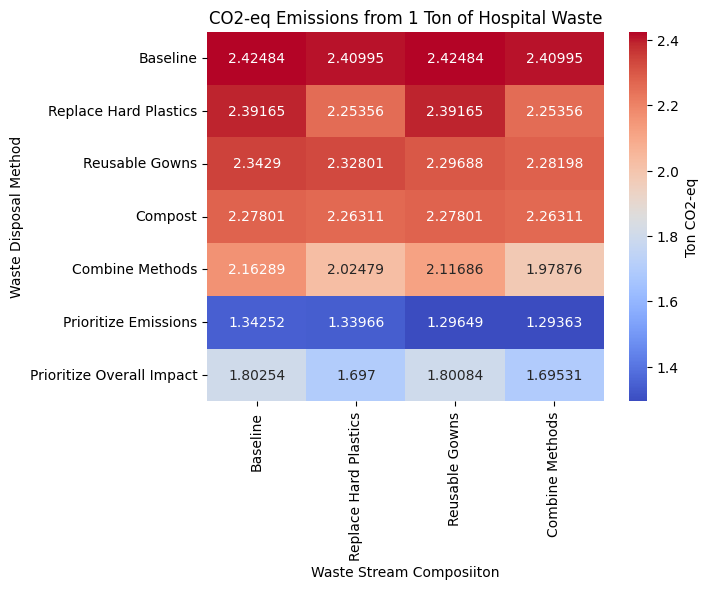

In [10]:
produce_heatmap(results_co2, 'CO2-eq Emissions from 1 Ton of Hospital Waste', 'Ton CO2-eq', 'HeatmapEmissions')

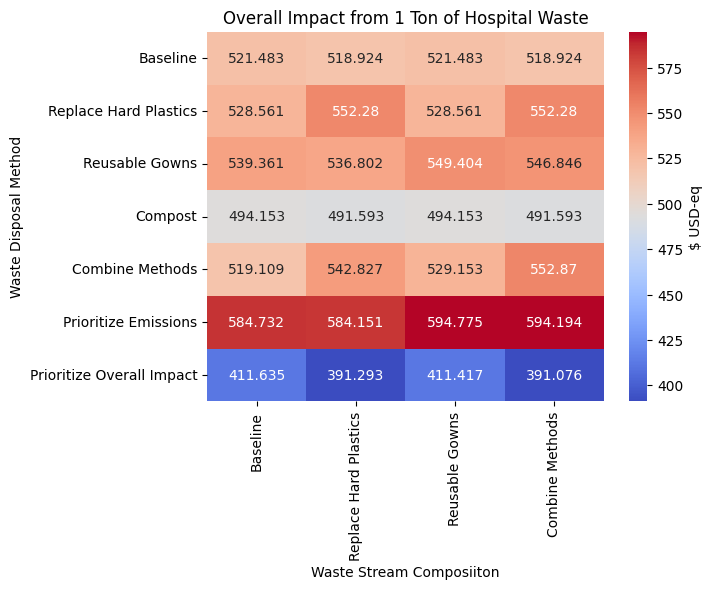

In [11]:
produce_heatmap(results_tot, 'Overall Impact from 1 Ton of Hospital Waste', '$ USD-eq', 'HeatmapImpact')

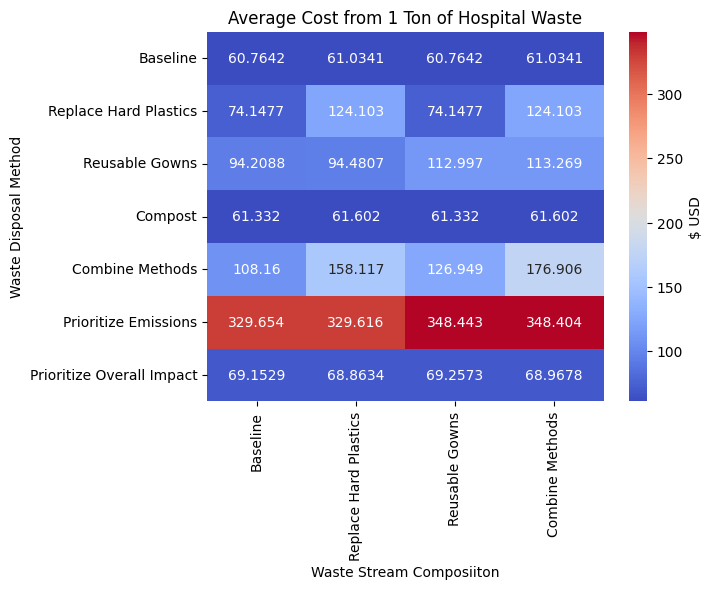

In [12]:
produce_heatmap(results_cost, 'Average Cost from 1 Ton of Hospital Waste', '$ USD', 'HeatmapCost')

## Disposal Method Sankey Diagrams

In [18]:
auxillary_labels = ['CO2-eq Emissions', 'Social Cost', 'Disposal Cost', 'Total Cost', 'Medical Waste']
labels = composition_type_names + disposal_method_names + auxillary_labels
for idx, label in enumerate(labels):
    print(str(idx), label)

0 Hard plastic
1 Soft plastic
2 Paper
3 Food
4 Textiles
5 Glass
6 Metal
7 Electronic waste
8 Sharps
9 Landfill
10 Recycling
11 Waste-to-Energy
12 Composting
13 Reuse
14 CO2-eq Emissions
15 Social Cost
16 Disposal Cost
17 Total Cost
18 Medical Waste


In [19]:
# impact_co2_total_20
# impact_cost
def plot_sankey(composition, disposal_methods, emissions_impact_matrix, cost_impact_matrix, name=None):
    method_offset = 9
    post_method_offset = 14
    sources = []
    targets = []
    counts  = []

    # Calculate impact matrices
    disposal_co2_direct     = assess_impact(composition, disposal_methods, emissions_impact_matrix)
    disposal_cost_direct    = assess_impact(composition, disposal_methods, cost_impact_matrix)
    disposal_co2_cost       = disposal_co2_direct * social_cost_carbon

    norm_0 = 100. / sum(composition)
    norm_1 = 100. / sum(sum(disposal_methods))
    norm_2 = 100. / sum(sum(disposal_co2_cost))
    norm_3 =  100/ sum([sum(x) for x in disposal_co2_cost]) / sum([sum(x) for x in disposal_co2_direct]) 

    print(norm_0 * sum(composition))
    print(norm_1 * sum(sum(disposal_methods)))
    print(norm_2 * sum(sum(disposal_co2_cost)))

    for c in range(len(composition)):
        sources.append(18)
        targets.append(c)
        counts.append(composition[c] * norm_0)
        

    # Composition to disposal matrix
    for m in range(len(disposal_methods)):
        for c in range(len(disposal_methods[m])):
            if disposal_methods[m][c] != 0.0:
                sources.append(c)
                targets.append(method_offset + m)
                counts.append(disposal_methods[m][c] * norm_1)

    
    # Disposal to CO2 direct matrix
    sum_CO2_direct = [sum(x) for x in disposal_co2_direct]
    for m in range(len(disposal_methods)):
        if sum_CO2_direct[m] != 0.0:
            sources.append(method_offset + m)
            targets.append(14)
            counts.append(sum_CO2_direct[m] * norm_2)

    # Disposal to CO2 cost matrix
    sum_co2_cost = sum([sum(x) for x in disposal_co2_cost])
    sources.append(14)
    targets.append(15)
    counts.append(sum_co2_cost * norm_2)

    # Disposal to direct cost matrix
    sum_cost_direct = [sum(x) for x in disposal_cost_direct]
    for m in range(len(disposal_methods)):
        if sum_cost_direct[m] != 0.0:
            sources.append(method_offset + m)
            targets.append(16)
            counts.append(sum_cost_direct[m])
    
    sources.append(15)
    targets.append(17)
    counts.append(sum_co2_cost)

    sources.append(16)
    targets.append(17)
    counts.append(sum(sum_cost_direct))

    if name != None:
        fig = go.Figure(data=[go.Sankey(
            arrangement='snap',
            node = {"label": labels},
            link = {"source": sources, "target": targets, "value": counts}
            )])
        fig.update_layout(title=name)
    else:
        fig = go.Figure(data=[go.Sankey(
            node = {"label": labels},
            link = {"source": sources, "target": targets, "value": counts}
            )])
    fig.show()

In [20]:
graph_pairs = [(0, 0), (3, 5), (3, 4)]
for pair in graph_pairs:
    waste_method_labels, waste_composition_labels
    title = 'Total Impact Sankey Diagram:\n' + waste_composition_labels[pair[0]] + ' Compsition, ' + waste_method_labels[pair[1]] + " Disposal"
    print(title)
    plot_sankey(waste_compositions[pair[0]], waste_methods[pair[1]], impact_co2_total_20, impact_cost, title)

Total Impact Sankey Diagram:
Baseline Compsition, Baseline Disposal
100.0
100.0
100.0


Total Impact Sankey Diagram:
Combine Methods Compsition, Prioritize Emissions Disposal
100.0
100.0
100.0


Total Impact Sankey Diagram:
Combine Methods Compsition, Combine Methods Disposal
100.0
100.0
100.00000000000001


## Impact Matrices Heatmaps